In [1]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [2]:
data_dir = 'Preprocessed Data MI'
epoch_data_path = os.path.join(os.getcwd(), data_dir + '\Epoch')
dirs = os.listdir(os.path.join(os.getcwd(), 'Dataset Motor Imagery'))
eeg_data = [mne.read_epochs(os.path.join(epoch_data_path, epoch_file)) for epoch_file in os.listdir(epoch_data_path)]

Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectA-160405-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectA-160408-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     845.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
867 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectB-151110-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting 

In [53]:
epoch_data = []
epoch_label = []
subject_last_index = []
# scaler = StandardScaler()
for i in range(len(eeg_data)):
    eeg_data[i] = eeg_data[i].crop(tmin = 0, tmax = 0.845, include_tmax = True)
    for epoch in eeg_data[i].get_data():
#         epoch = scaler.fit_transform(epoch)
        epoch_data.append(np.reshape(epoch, newshape = (epoch.shape[0], epoch.shape[1], 1)))
    for event in eeg_data[i].events:
        epoch_label.append(event[2] - 1)
    subject_last_index.append((dirs[i].split('-')[1], len(epoch_data) - 1))
epoch_data = np.asarray(epoch_data, dtype = np.float32)
epoch_label = np.asarray(epoch_label, dtype = np.int32)

In [4]:
subject_index = {}
for subject, last_index in subject_last_index:
    if subject not in subject_index:
        subject_index[subject] = last_index
    if last_index > subject_index[subject]:
        subject_index[subject] = last_index
subject_index

{'SubjectA': 1825,
 'SubjectB': 5636,
 'SubjectC': 7535,
 'SubjectE': 10383,
 'SubjectF': 13257,
 'SubjectG': 15158,
 'SubjectH': 16080,
 'SubjectI': 17997}

In [5]:
def retrieve_data(subject_name):
    index_list = list(subject_index.values())
    subj_idx = list(subject_index.keys()).index(subject_name)
    if subj_idx - 1 < 0:
        data_index = list(range(index_list[subj_idx]))
    else:
        data_index = list(range(index_list[subj_idx - 1], index_list[subj_idx]))
    return epoch_data[data_index], epoch_label[data_index]

def sliding_window(data, new_data_len, data_gap):
    new_data_indices = []
    data_len = len(data)
    data_start_index, data_end_index = 0, new_data_len
    while data_end_index <= data_len:
        new_data_indices.append(list(range(data_start_index, data_end_index)))
        data_start_index += data_gap
        data_end_index += data_gap
    new_data = [data[data_indices] for data_indices in new_data_indices]
    return new_data

def add_noise(data, std_dev, mean = 0):
    noise = np.random.normal(mean, std_dev, size = data.shape)
    new_data = data + noise
    return new_data

def create_cnn(input_shape, optimizer = None):
    conv1_init = tf.keras.initializers.GlorotUniform(42)
    conv2_init = tf.keras.initializers.GlorotUniform(42)
    dense1_init = tf.keras.initializers.GlorotUniform(24)
    dense2_init = tf.keras.initializers.GlorotUniform(24)
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters = 64, kernel_size = (1, 5), padding = 'same', input_shape = input_shape,
                               activation = 'relu', kernel_initializer = conv1_init),
        tf.keras.layers.Conv2D(filters = 64, kernel_size = (input_shape[0], 1), activation = 'relu',
                               kernel_initializer = conv2_init),
        tf.keras.layers.AveragePooling2D(pool_size = (1, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = dense1_init),
        tf.keras.layers.Dense(units = 5, activation = 'softmax', kernel_initializer = dense2_init)
    ])
    if optimizer is None:
        model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(5 * 1e-5),
                      metrics = ['accuracy'])
    else:
        model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [54]:
subject_name = 'SubjectG'
data, labels = retrieve_data(subject_name)

In [55]:
data_length, data_gap = 150, 10
copy_data = data.copy()
epoch_data, epoch_label = [], []
for index, data in enumerate(copy_data):
    augmented_data = []
    for channel_index in range(data.shape[0]):
        augmented_data.append(sliding_window(data[channel_index, :, 0], data_length, data_gap))
    augmented_data = np.array(augmented_data)
    for data_index in range(augmented_data.shape[1]):
        new_data = augmented_data[:, data_index]
        new_label = labels[index]
        epoch_data.append(new_data)
        epoch_label.append(new_label)
epoch_data = np.array(epoch_data)
epoch_label = np.array(epoch_label)

In [56]:
print('Data shape after sliding window: {}'.format(epoch_data.shape))
print('Label shape after sliding window: {}'.format(epoch_label.shape))

Data shape after sliding window: (5703, 21, 150)
Label shape after sliding window: (5703,)


In [57]:
shuffled_indices = np.arange(epoch_data.shape[0])
np.random.shuffle(shuffled_indices)

In [58]:
epoch_data = epoch_data[shuffled_indices]
epoch_label = epoch_label[shuffled_indices]

In [11]:
strat_kfold = StratifiedKFold(n_splits = 10)

In [59]:
acc_scores = []
precisions, recalls = [], []
std_devs = [0.5, 0.6]
n_classes = len(np.unique(labels))
for train_index, test_index in strat_kfold.split(epoch_data, epoch_label):
    ## Split data based on the indices determined by StratifiedKFold
    train_data, test_data = epoch_data[train_index], epoch_data[test_index]
    train_labels, test_labels = epoch_label[train_index], epoch_label[test_index]
    
    ## Noise addition
    copy_data = train_data.copy()
    train_data, train_labels = list(train_data), list(train_labels)
    for index, data in enumerate(copy_data):
        for dev in std_devs:
            train_data.append(add_noise(data, std_dev = dev))
            train_labels.append(train_labels[index])
    train_data, train_labels = np.array(train_data), np.array(train_labels)
    print('Train data after noise addition: {}'.format(train_data.shape))
    
    ## Transform data before training
    train_data = tf.expand_dims(train_data, axis = -1)
    test_data = tf.expand_dims(test_data, axis = -1)
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = n_classes)
    test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = n_classes)
    input_shape = (train_data.shape[1], train_data.shape[2], train_data.shape[3])
    
    ## Start training
    n_epochs = 10
    model = create_cnn(input_shape = input_shape)
    history = model.fit(train_data, train_labels, batch_size = 16, validation_data = (test_data, test_labels),
                        epochs = n_epochs)
    
    ## Make predictions and assess model performance
    predictions = model.predict(test_data)
    predictions = np.array([np.argmax(prediction) for prediction in predictions])
    real_label = np.array([np.argmax(label) for label in test_labels])
    _, acc = model.evaluate(test_data, test_labels)
    acc_scores.append(acc)
    precisions.append(precision_score(real_label, predictions, average = 'weighted'))
    recalls.append(recall_score(real_label, predictions, average = 'weighted'))

Train data after noise addition: (15396, 21, 150)
Epoch 1/10
963/963 [==============================] - 30s 32ms/step - loss: 1.2800 - accuracy: 0.4417 - val_loss: 1.2167 - val_accuracy: 0.4781
Epoch 2/10
963/963 [==============================] - 34s 35ms/step - loss: 0.9571 - accuracy: 0.6050 - val_loss: 1.1707 - val_accuracy: 0.4764
Epoch 3/10
963/963 [==============================] - 35s 36ms/step - loss: 0.7785 - accuracy: 0.6946 - val_loss: 1.1729 - val_accuracy: 0.4869
Epoch 4/10
963/963 [==============================] - 36s 37ms/step - loss: 0.6336 - accuracy: 0.7621 - val_loss: 1.1686 - val_accuracy: 0.4956
Epoch 5/10
963/963 [==============================] - 36s 37ms/step - loss: 0.5059 - accuracy: 0.8191 - val_loss: 1.2085 - val_accuracy: 0.5289
Epoch 6/10
963/963 [==============================] - 36s 38ms/step - loss: 0.3936 - accuracy: 0.8752 - val_loss: 1.2477 - val_accuracy: 0.5184
Epoch 7/10
963/963 [==============================] - 37s 39ms/step - loss: 0.2967 - a

Epoch 3/10
963/963 [==============================] - 40s 41ms/step - loss: 0.7875 - accuracy: 0.6916 - val_loss: 1.0435 - val_accuracy: 0.5474
Epoch 4/10
963/963 [==============================] - 40s 42ms/step - loss: 0.6441 - accuracy: 0.7578 - val_loss: 1.0538 - val_accuracy: 0.5614
Epoch 5/10
963/963 [==============================] - 40s 41ms/step - loss: 0.5142 - accuracy: 0.8154 - val_loss: 1.0765 - val_accuracy: 0.5789
Epoch 6/10
963/963 [==============================] - 42s 44ms/step - loss: 0.3954 - accuracy: 0.8732 - val_loss: 1.1715 - val_accuracy: 0.5825
Epoch 7/10
963/963 [==============================] - 45s 46ms/step - loss: 0.2969 - accuracy: 0.9159 - val_loss: 1.2322 - val_accuracy: 0.5754
Epoch 8/10
963/963 [==============================] - 39s 40ms/step - loss: 0.2102 - accuracy: 0.9501 - val_loss: 1.3596 - val_accuracy: 0.5912
Epoch 9/10
963/963 [==============================] - 42s 43ms/step - loss: 0.1498 - accuracy: 0.9733 - val_loss: 1.4126 - val_accuracy:

In [60]:
df = pd.DataFrame({'Accuracy': acc_scores, 'Precision': precisions, 'Recall': recalls})
df.to_csv('Hasil/{}_SKF.csv'.format(subject_name))

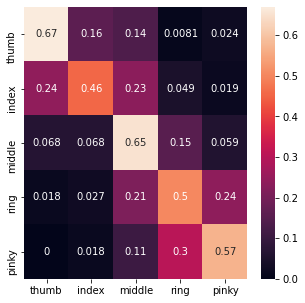

In [61]:
label = ['thumb', 'index', 'middle', 'ring', 'pinky']
cm = confusion_matrix(real_label, predictions, normalize = 'true')
df_cm = pd.DataFrame(cm, index = label, columns = label)
plt.figure(figsize = (5, 5))
sn.heatmap(df_cm, annot = True)
plt.savefig('Hasil/CM_{}.png'.format(subject_name), facecolor = 'w', edgecolor = 'w')
plt.show()

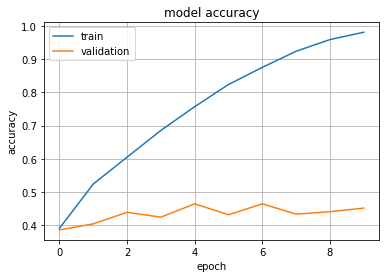

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('Hasil/Combination.png')
plt.grid(True)
plt.show()

In [16]:
df

,Accuracy,Precision,Recall
0,0.416058,0.421012,0.416058
1,0.452555,0.457111,0.452555
2,0.463504,0.466867,0.463504
3,0.468978,0.467463,0.468978
4,0.498175,0.497947,0.498175
5,0.447898,0.457142,0.447898
6,0.447898,0.449712,0.447898
7,0.411335,0.426854,0.411335
8,0.444241,0.446678,0.444241
9,0.451554,0.450043,0.451554
